In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams.update({'font.size': 15})

#G=Goal, OG=Own Goal, Y=Yellow Card, R=Red Card, SY = Red Card by second yellow, P=Penalty, MP=Missed Penalty, I = Substitution In, O=Substitute Out, IH= In half time?

df_matches = pd.read_csv('data_raw/WorldCupMatches.csv', sep=',')
df_players = pd.read_csv('data_raw/WorldCupPlayers.csv', sep=',')
df_cups = pd.read_csv('data_raw/WorldCups.csv', sep=',')

df_events = pd.read_csv('data_prepared/event.csv', sep=',').replace(np.nan, '', regex=True)
df_penalties = pd.read_csv('data_prepared/penalties.csv', encoding='iso-8859-1', sep=',')

# Wie oft hat sich ein zurückliegendes Team den Sieg geholt?

In [2]:
ht_wins_after_residual = 0
at_wins_after_residual = 0
halftime_tie = 0
regular_time_tie = 0
leading_team_wins = 0

df_grouped_events = df_events.groupby(["MatchID"]).mean()

for index, row in df_grouped_events.iterrows():
    # ignore penalties and extra time
    if row["Penalty"] == True or row["ExtraTime"] == True:
        continue
    if row["Half-time Home Goals"] == row["Half-time Away Goals"]:
        halftime_tie+=1
        continue
    if row["Home Team Goals"] == row["Away Team Goals"]:
        regular_time_tie +=1
        continue
    if row["Half-time Home Goals"] > row["Half-time Away Goals"] and row["Home Team Goals"] < row["Away Team Goals"]:
        at_wins_after_residual+=1
        continue
    if row["Half-time Home Goals"] < row["Half-time Away Goals"] and row["Home Team Goals"] > row["Away Team Goals"]:
        ht_wins_after_residual+=1
        continue  
    leading_team_wins+=1
    

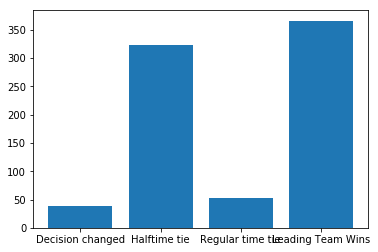

In [3]:
decision_changed_after_ht = ht_wins_after_residual + at_wins_after_residual
y = [decision_changed_after_ht, halftime_tie, regular_time_tie, leading_team_wins]
x = ["Decision changed", "Halftime tie", "Regular time tie", "Leading Team Wins"]
plt.bar(x = x, height = y)

plt.show()

In [4]:
total_matches = decision_changed_after_ht + halftime_tie + regular_time_tie + leading_team_wins

In [5]:
decision_changed_after_ht

38

In [6]:
total_matches

779

## Antwort: Von knapp 780 Spielen werden weniger als 40 Spiele gedreht

### Hier wird nicht berücksichtigt: Spiele mit Elfmeterschießen oder Nachspielzeit und es wird nicht zwischen Gruppen- und KO-Phase unterschieden

# Wann steht der Gewinner fest?

In [7]:
# data preparation: event data since 1986
df_relevant_events=df_events.loc[(df_events['Year'] >= 1986)]

In [8]:
df_relevant_events = df_relevant_events.groupby(["MatchID"]).mean()

In [9]:
first_half_decided_group = 0
second_half_decided_group = 0
first_half_decided = 0
second_half_decided = 0
extra_time_decided = 0
penalty_decided = 0

for index, row in df_relevant_events.iterrows():
    if row["Home Team Goals"] == row["Half-time Home Goals"] and row["Away Team Goals"] == row["Half-time Away Goals"] and row["Penalty"] == False:
        if row["Home Team Goals"] == row["Away Team Goals"]:
            continue
        if row["StageRank"] > 1:
            first_half_decided+=1
        else:
            first_half_decided_group+=1
        continue
    if row["ExtraTime"] == True and row["Penalty"] == False:
        extra_time_decided+=1
        continue
    if row["Penalty"] == True:
        penalty_decided+=1
        continue
    if row["StageRank"] > 1:
        second_half_decided+=1
    else:
        second_half_decided_group+=1

## Betrachtung der KO-Phase

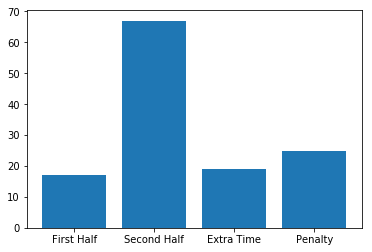

In [10]:
match_decisions = [first_half_decided, second_half_decided, extra_time_decided, penalty_decided]
match_axis = ["First Half", "Second Half", "Extra Time", "Penalty"]
plt.bar(x = match_axis, height = match_decisions)

plt.show()

## Betrachtung der Gruppen-Phase

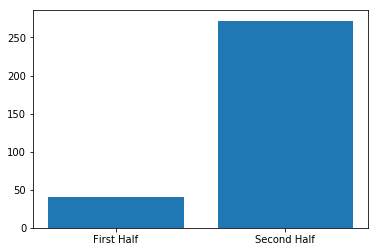

In [11]:
match_decisions = [first_half_decided_group, second_half_decided_group]
match_axis = ["First Half", "Second Half"]
plt.bar(x = match_axis, height = match_decisions)

plt.show()

# Vorhersage zu welcher Spielphase sich ein Spiel entscheidet

In [12]:
# data prep
df_relevant_events # events since 1986
df_relevant_events = df_relevant_events.groupby(["MatchID"]).mean()
# df_relevant_events

In [13]:
# lambda function
def calculateDecisionPhase(x):
    if x["Home Team Goals"] == x["Half-time Home Goals"] and x["Away Team Goals"] == x["Half-time Away Goals"] and x["Penalty"] == False:
        if x["Home Team Goals"] == x["Away Team Goals"]:
            return 0
        else:
            return 1
    if x["ExtraTime"] == True and x["Penalty"] == False:
        return 3
    if x["Penalty"] == True:
        return 4
    return 2

In [14]:
def calculateWorldCupStage(x):
    if x["StageRank"] == 1:
        return 0 # group phase
    return 1 # ko phase

In [15]:
df_relevant_events_truth = df_relevant_events
df_relevant_events_truth["DecisionPhase"] = df_relevant_events_truth.apply(calculateDecisionPhase, axis=1)
df_relevant_events_truth["WorldCupStage"] = df_relevant_events_truth.apply(calculateWorldCupStage, axis=1)

# df_relevant_events_truth

## KNN

In [16]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


df_relevant_events_truth[["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"]] = scaler.fit_transform(df_relevant_events_truth[["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"]])
# Values
x = np.array(df_relevant_events_truth[["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"]])

# Labels
y = np.array(df_relevant_events_truth["DecisionPhase"]) 

In [17]:
# Split data
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=101)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# fit decision tree
clf = KNeighborsClassifier()
clf = clf.fit(X_train, Y_train)

# compute accuracy
y_pred = clf.predict(X_test)
score = clf.score(X_test, Y_test)

train_score = accuracy_score(clf.predict(X_train), Y_train)

In [19]:
train_score

0.9669669669669669

In [20]:
y_pred

array([2, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 0, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 0, 4, 2, 2, 3, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 4, 4, 2, 2,
       2, 2, 1, 2, 2, 2, 0, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 1, 2, 0, 2, 2, 2], dtype=int64)

In [21]:
score

0.9370629370629371

In [22]:
# for comparison also compute accuracy for base model (always output zero)
y_base_pred = np.full(shape = (len(Y_test)), fill_value=2) # two as most matches are decided in second half 
base_score = accuracy_score(y_base_pred, Y_test)

In [23]:
base_score

0.6923076923076923

## Ergebnis des KNN: 
* Knapp 440 Datensätze
* Insgesamt 7 Features (Merkmale des Datensatzes)
    * Home Team Goals
    * Away Team Goals
    * Half Time Home Goals
    * Half Time Away Goals
    * Entra Time?
    * Penalty?
* Trainings Accuracy: 96,6%
* Test Accuracy: 93,7%
* Base Accuracy: 69,2% (Base = 2. Halbzeit entscheidend)

## Decision Tree

In [24]:
from sklearn import tree
from sklearn.metrics import accuracy_score

# fit decision tree
clf = tree.DecisionTreeClassifier(max_depth = 7)
clf = clf.fit(X_train, Y_train)

# compute accuracy
y_pred = clf.predict(X_test)
score = clf.score(X_test, Y_test)

train_score = accuracy_score(clf.predict(X_train), Y_train)

In [25]:
y_pred

array([2, 0, 2, 4, 1, 2, 2, 1, 2, 2, 2, 4, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 0, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 0, 4, 2, 2, 3, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 4, 4, 2, 2,
       2, 2, 1, 2, 2, 2, 0, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 1, 2, 2, 3, 1, 2, 0, 2, 2, 2], dtype=int64)

In [26]:
score

0.986013986013986

In [27]:
train_score

0.984984984984985

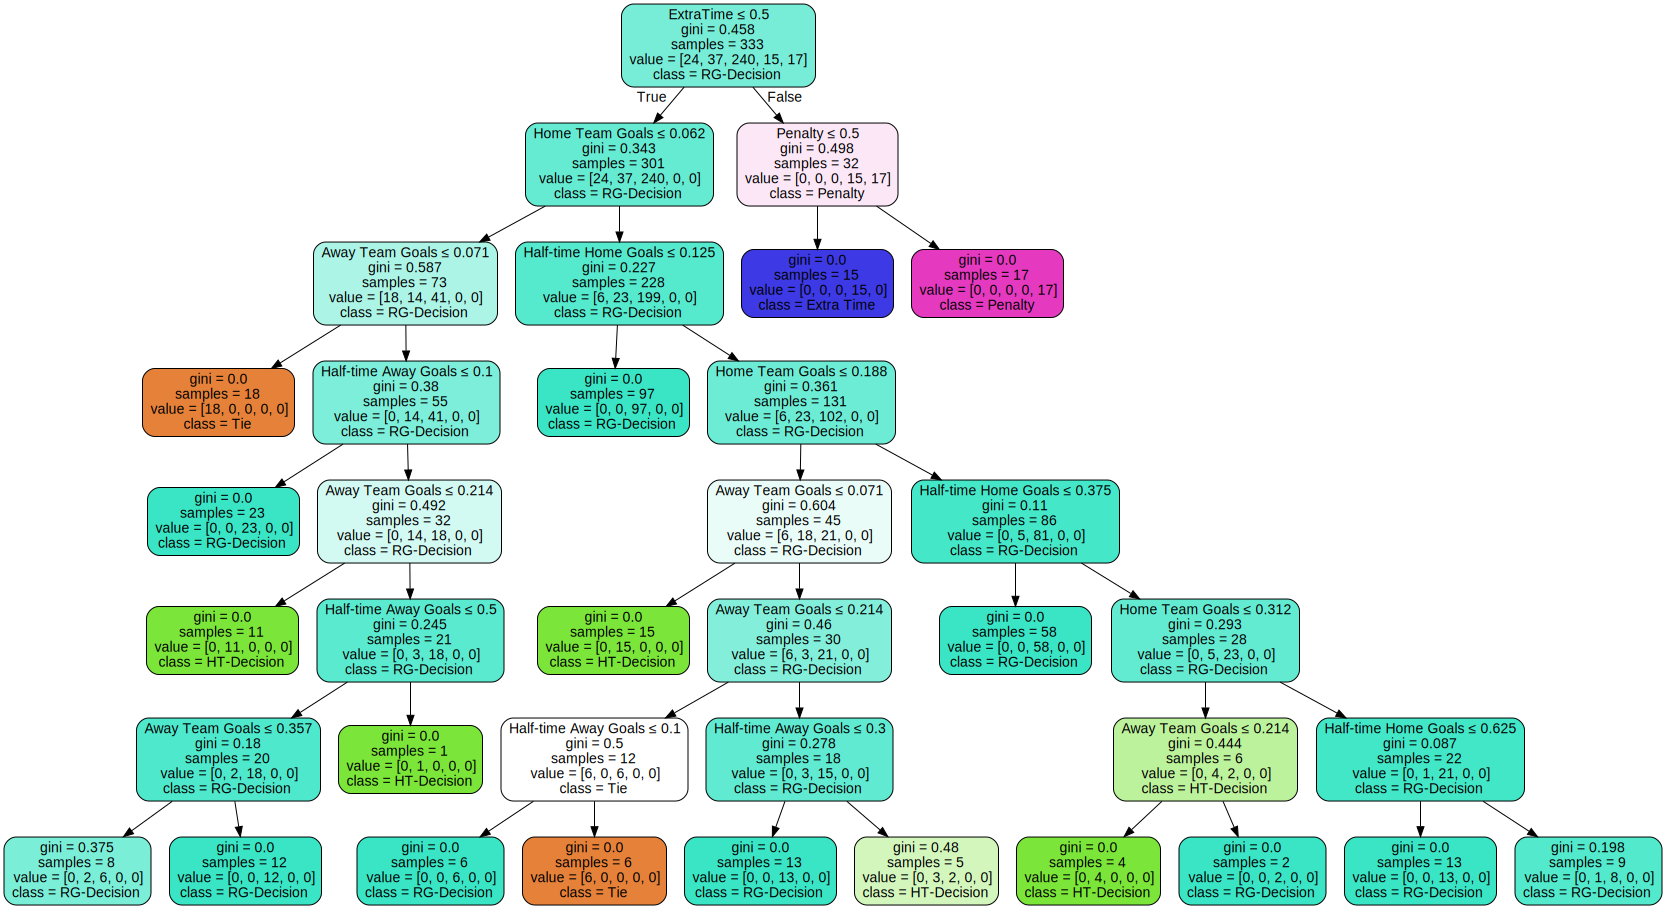

In [28]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"],  
                         class_names=["Tie", "HT-Decision", "RG-Decision", "Extra Time", "Penalty"],  
                         filled=True, rounded=True,  
                         special_characters=True) 

graph = graphviz.Source(dot_data)  
graph

## Ergebnis des Decision Tree: 
* Knapp 440 Datensätze
* Insgesamt 7 Features (Merkmale des Datensatzes)
    * Home Team Goals
    * Away Team Goals
    * Half Time Home Goals
    * Half Time Away Goals
    * Entra Time?
    * Penalty?
* Trainings Accuracy: 98,5%
* Test Accuracy: 98,6%
* Base Accuracy: 69,2% (Base = 2. Halbzeit entscheidend)

# Erfolgsquote von Strafstößen

In [29]:
df_penalties_success_rate = df_events[(df_events.EventType.str.contains("P") == True)]

In [30]:
f = {
     'EventType':'count'
    }

df_penalties_success_rate = df_penalties_success_rate[["EventType"]].groupby(["EventType"]).agg(f)

In [31]:
df_penalties_success_rate

,EventType
EventType,
MP,11
P,178


In [32]:
df_penalties_MP = df_penalties_success_rate.loc["MP"]

In [33]:
df_penalties_P = df_penalties_success_rate.loc["P"]

In [34]:
df_penalties_MP

EventType    11
Name: MP, dtype: int64

In [35]:
df_penalties_P

EventType    178
Name: P, dtype: int64

In [36]:
df_penalty_quote = print(float(df_penalties_MP) / df_penalties_P)


EventType    0.061798
Name: P, dtype: float64


## Antwort: Nur 6,17 % der Strafstöße werden verschossen

# General information about Football World Cups

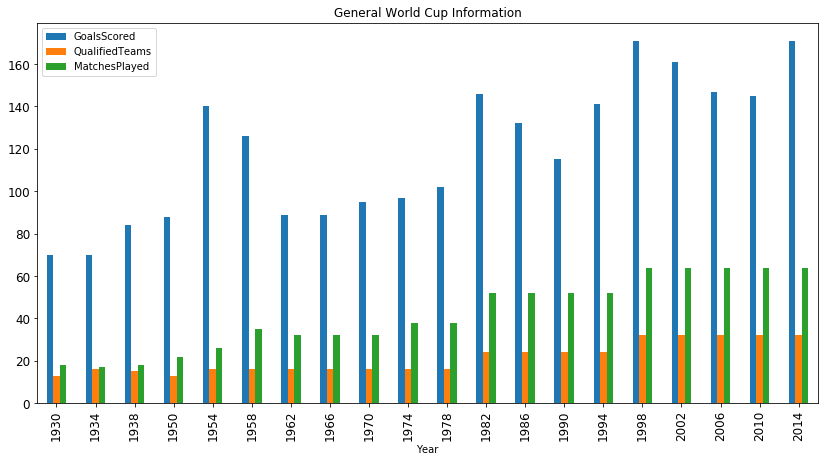

In [37]:
df_cups.set_index('Year').plot(kind='bar', title="General World Cup Information", figsize=(14,7), legend=True, fontsize=12)
plt.show()

# Attendance per World Cup

In [38]:
# Data preparation
df_cups_attendance = df_cups[["Year", "Attendance"]]
df_cups_attendance['Attendance'] = df_cups_attendance['Attendance'].str.replace('.', '')
df_cups_attendance['Attendance'] = df_cups_attendance.Attendance.astype(float)
df_cups_attendance.dtypes

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Year            int64
Attendance    float64
dtype: object

## Total Attendance per World Cup

<Figure size 864x432 with 0 Axes>

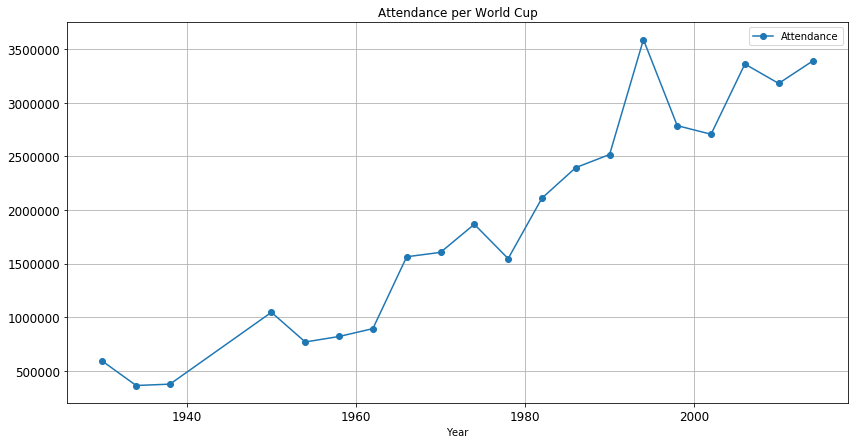

In [39]:
plt.figure(figsize=(12,6))
df_cups_attendance.set_index("Year").plot(style="o-", title="Attendance per World Cup", figsize=(14,7), legend=True, fontsize=12)
plt.grid()
plt.show()

## Average Attendance per World Cup

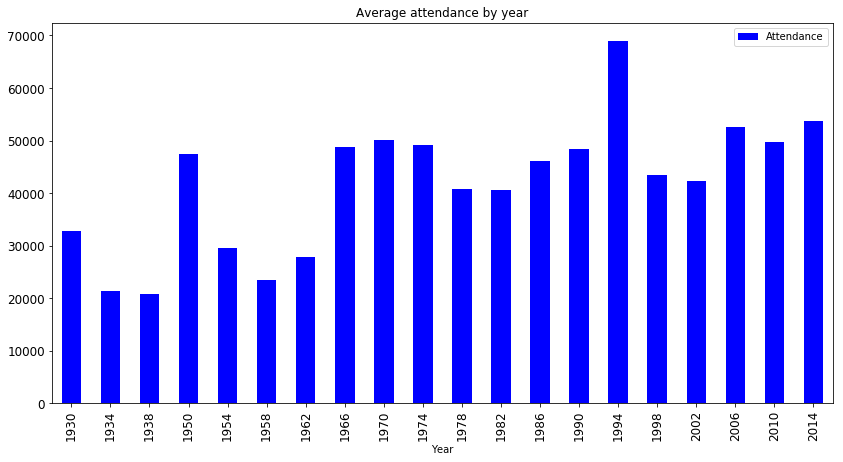

In [40]:
df_avg_attendance = df_matches.groupby("Year")["Attendance"].mean().reset_index()
df_avg_attendance["Year"] = df_avg_attendance["Year"].astype(int)
df_avg_attendance.set_index("Year").plot(kind='bar', color="b", title="Average attendance by year", figsize=(14,7), legend=True, fontsize=12)
plt.show()

# Player with the most goals across all World Cups

In [41]:
# https://www.weltfussball.de/ewige_torjaeger/wm/tore/1/
# data consistency not sufficient for this calculation as player names are not unique

In [42]:
df_players_goals = df_events[["Player Name", "EventType"]]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("G") == True]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("P") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("I") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("Y") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("R") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("O") == False]

df_players_goals.groupby(["Player Name"])
df_players_goals.dropna()

,Player Name,EventType
2,Marcel LANGILLER,G
3,Juan CARRENO,G
6,Andre MASCHINOT,G
7,Andre MASCHINOT,G
15,Lucien LAURENT,G
36,Tom FLORIE,G
42,Bart McGHEE,G
46,Bert PATENAUDE,G
74,Ivica BEK,G
75,PREGUINHO,G


## List of top scoring players

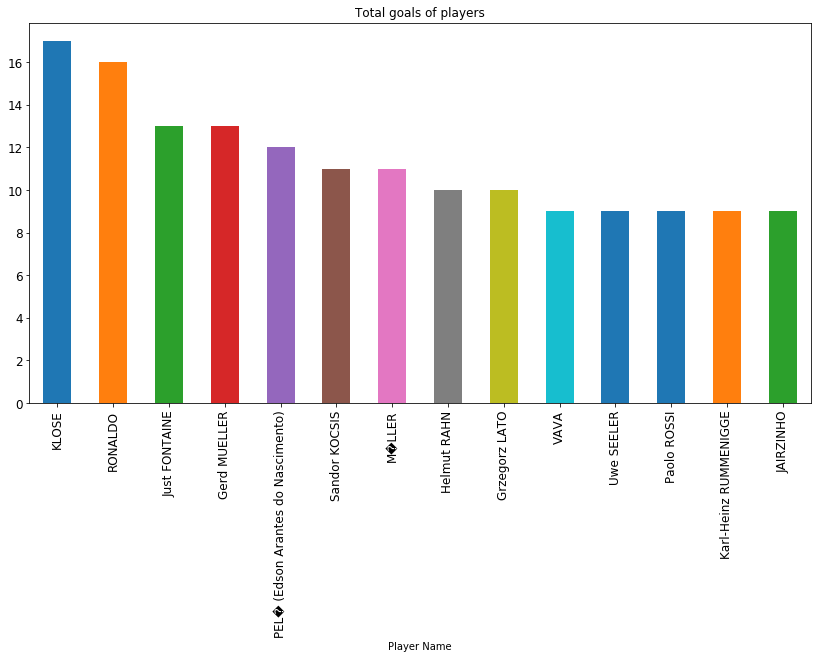

In [43]:
f = {
     'EventType':'count'
    }

df_test = df_players_goals.groupby(['Player Name']).agg(f)
df_test['EventType'].sort_values(ascending=False)
df_top_players = df_players_goals.groupby(['Player Name']).agg(f)
df_top_players['EventType'].sort_values(ascending=False)
df_top14_players = df_top_players[df_test.EventType > 8]
df_top14_players['EventType'].sort_values(ascending=False).plot(kind='bar', title="Total goals of players", figsize=(14,7), legend=False, fontsize=12)
plt.show()

# Fun with Penalty data

The used dataset covers only penalty shoot-outs after regular time. Penalty shoot-outs were introduced in 1972.

In [44]:
# data preparation
df_penalties["Match Result"] = df_penalties["Match Result"].str.replace("","-")
df_penalties["Final Result"] = df_penalties["Final Result"].str.replace("","-")

df_penalties["Winner Penalty Goals"] = df_penalties["Final Result"].str.split("-").str[0]
df_penalties["Loser Penalty Goals"]  = df_penalties["Final Result"].str.split("-").str[1]

## Penalty overview

In [45]:
df_penalties

,Winner,Match Result,Loser,Year,Final Result,Round,Winner Penalty Goals,Loser Penalty Goals
0,Germany,3-3,France,1982,5-4,Semi-finals,5,4
1,France,1-1,Brazil,1986,4-3,Quarter-finals,4,3
2,Germany,0-0,Mexico,1986,4-1,Quarter-finals,4,1
3,Belgium,1-1,Spain,1986,5-4,Quarter-finals,5,4
4,Republic of Ireland,0-0,Romania,1990,5-4,Second round,5,4
5,Argentina,0-0,Yugoslavia,1990,3-2,Quarter-finals,3,2
6,Argentina,1-1,Italy,1990,4-3,Semi-finals,4,3
7,Germany,1-1,England,1990,4-3,Semi-finals,4,3
8,Bulgaria,1-1,Mexico,1994,3-1,Second round,3,1
9,Sweden,2-2,Romania,1994,5-4,Quarter-finals,5,4


## How many matches were dicided after penalty shoot-outs?

In [46]:
df_penalties[['Winner']].count()

Winner    26
dtype: int64

Between 1982 and 2014 took 26 penalty shoot-outs place

## How many penalty matches by year?

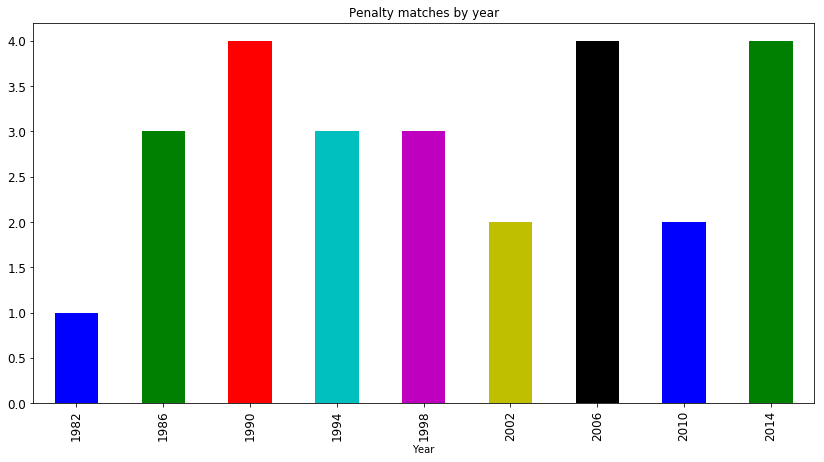

In [47]:
df_penalties_by_year = df_penalties['Year'].value_counts().reset_index()
df_penalties_by_year.columns = ['Year', 'Count']
df_penalties_by_year = df_penalties_by_year.sort_values(by='Year',ascending=True)
df_penalties_by_year.set_index("Year").plot(kind='bar',color='bgrcmyk', title="Penalty matches by year", figsize=(14,7), legend=False, fontsize=12)
plt.show()

## When decided a penalty shoot-out the world cup winner?

In [48]:
df_penalties[df_penalties['Round'] == 'Final']

,Winner,Match Result,Loser,Year,Final Result,Round,Winner Penalty Goals,Loser Penalty Goals
10,Brazil,0-0,Italy,1994,3-2,Final,3,2
19,Italy,1-1,France,2006,5-3,Final,5,3


In 1994 won Brazil against Italy with the endresult of 3:2, and in 2006 won Italy against France in the world cup final 5:3.

## Which team is the most successful on penalties?

In [49]:
df_penalty_winners = df_penalties["Winner"].value_counts().reset_index()
df_penalty_winners.columns = ["Country","Number of wins"]
df_penalty_winners.sort_values(by='Number of wins',ascending=False)

,Country,Number of wins
0,Argentina,4
1,Germany,4
2,Brazil,3
3,France,2
10,Bulgaria,1
15,Spain,1
14,Sweden,1
13,Republic of Ireland,1
12,Belgium,1
11,Italy,1


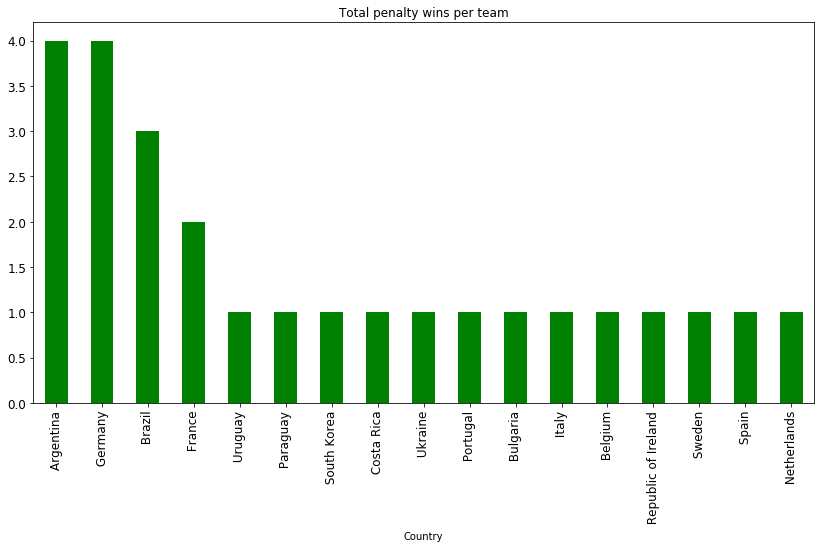

In [50]:
df_penalty_winners.set_index("Country").plot(kind="bar", color="g", title="Total penalty wins per team", figsize=(14,7), legend=False, fontsize=12)
plt.show()

## Which team is the less successful on penalty?

In [51]:
df_penalty_loosers = df_penalties["Loser"].value_counts().reset_index()
df_penalty_loosers.columns = ["Country","Number of loses"]
df_penalty_loosers.sort_values(by='Number of loses',ascending=False)

,Country,Number of loses
0,Italy,3
1,England,3
2,Spain,2
3,Netherlands,2
4,France,2
5,Mexico,2
6,Romania,2
12,Costa Rica,1
15,Japan,1
14,Brazil,1


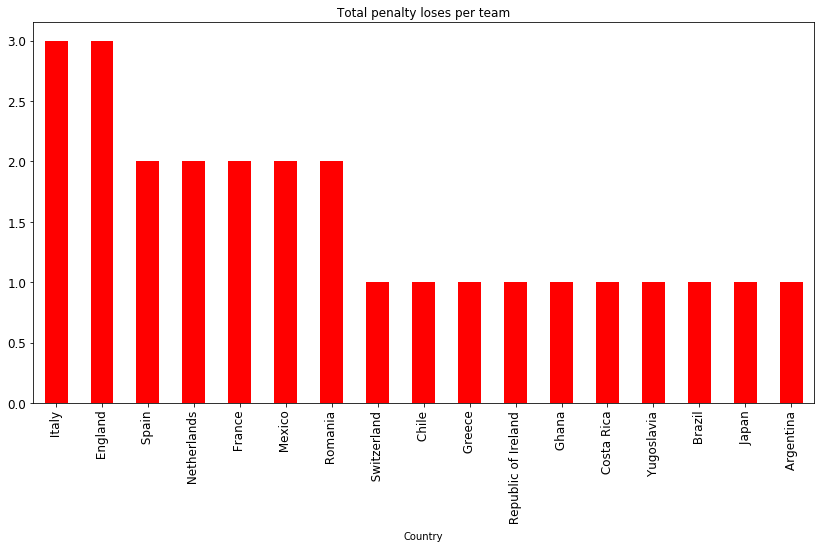

In [52]:
df_penalty_loosers.set_index("Country").plot(kind="bar", color="r", title="Total penalty loses per team", figsize=(14,7), legend=False, fontsize=12)
plt.show()

# How many Goals per Worldcup?

Year
1930     70
1934     70
1938     84
1950     88
1954    140
1958    126
1962     89
1966     89
1970     95
1974     97
1978    102
1982    146
1986    132
1990    115
1994    141
1998    171
2002    161
2006    147
2010    145
2014    171
dtype: int64


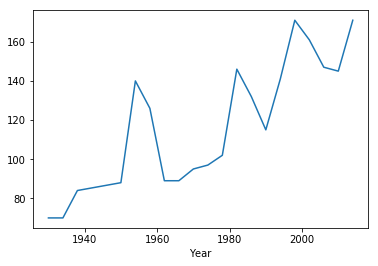

In [53]:
goals_per_match = df_events.groupby(['MatchID'])[['Year', 'Home Team Goals', 'Away Team Goals']].mean()
goals_per_world_cup = goals_per_match.groupby(['Year'])[['Home Team Goals', 'Away Team Goals']].sum()
print(goals_per_world_cup.sum(1))
goals_per_world_cup.sum(1).plot()
plt.show()

# Okay seems like more goals occured lately, so lets check the average goals per game for each world cup

     Average Goals per Game
                           
Year                       
1930               0.257143
1934               0.242857
1938               0.214286
1950               0.250000
1954               0.185714
1958               0.277778
1962               0.359551
1966               0.359551
1970               0.336842
1974               0.391753
1978               0.372549
1982               0.356164
1986               0.393939
1990               0.452174
1994               0.368794
1998               0.374269
2002               0.397516
2006               0.435374
2010               0.441379
2014               0.374269


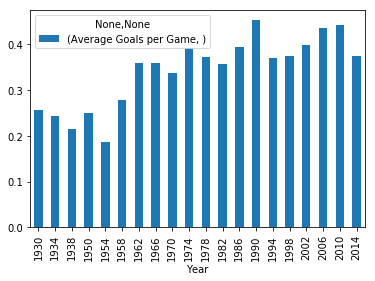

In [54]:
goals_per_match_ratio = df_events.groupby(['MatchID'])[['MatchID', 'Year', 'Home Team Goals', 'Away Team Goals']].mean()
goals_per_match_ratio = goals_per_match_ratio.assign(total = lambda x: x['Home Team Goals'] + x['Away Team Goals'])
goals_per_match_ratio = goals_per_match_ratio[['MatchID', 'Year', 'total']]
goals_per_match_ratio = goals_per_match_ratio.groupby(['Year'])[['MatchID', 'total']].agg({'MatchID' : ['size'], 'total' : ['sum']})
goals_per_match_ratio = goals_per_match_ratio.rename(columns={'size':'Number of Games', 'sum' : 'Amount of Goals'})
goals_per_match_ratio = goals_per_match_ratio.assign(average = lambda x: (x['MatchID']['Number of Games'].astype(dtype=float) / x['total']['Amount of Goals'].astype(dtype=float)) )
goals_per_match_ratio = goals_per_match_ratio[['average']].rename(columns={'average':'Average Goals per Game'})
print(goals_per_match_ratio)
goals_per_match_ratio.plot(kind='bar')
plt.show()

Well it seems that yes, the average number of goals per game increased since 1930 but lately the average was more or less consistent with some peaks in the 00´s

# Next up we ask ourself: has the goalkeeper ever shot a goal?


In [55]:
goal_keeper_goal = df_events.loc[(df_events['EventType'] == 'G') & (df_events['Position'] == 'GK')]

print(goal_keeper_goal)

Empty DataFrame
Columns: [Year, Datetime, Stage, Stadium, City, Home Team Name, Home Team Goals, Away Team Goals, Away Team Name, Attendance, Half-time Home Goals, Half-time Away Goals, Referee, Assistant 1, Assistant 2, RoundID, MatchID, Home Team Initials, Away Team Initials, Team Initials, Coach Name, Line-up, Shirt Number, Player Name, Position, EventType, EventMinute, ExtraTime, Penalty, GoldenGoal, DecisionPenaltyAway, DecisionPenaltyHome, HomeTeamWins, AwayTeamWins, EventOfHomeTeam, EventOfWinner, EventOfLoser, HourGameStart, StageRank]
Index: []

[0 rows x 39 columns]


# Unfortunately no goal keeper has ever shot a goal during world cup

# Next Question is: Does the team from from the country hosting the event perform better than otherwise?

# Therefore first take a look at the host and the finals for each world cup

In [59]:
df_events2 = pd.read_csv('data_prepared/events2.csv', sep=';').replace(np.nan, '', regex=True)

host_and_winner = df_events2.loc[(df_events2['Stage'] == 'Final')]
host_and_winner = host_and_winner[['Year', 'Host Team Name', 'Home Team Name', 'Home Team Goals', 'Away Team Name', 'Away Team Goals', 'GoldenGoal', 'Penalty', 'DecisionPenaltyAway', 'DecisionPenaltyHome']]
host_and_winner = host_and_winner.drop_duplicates()
def calcChamp(x):
    if x['Penalty']:
        return x['Home Team Name'] if x['DecisionPenaltyHome'] > x['DecisionPenaltyAway'] else x['Away Team Name']
    else:
        return x['Home Team Name'] if x['Home Team Goals'] > x['Away Team Goals'] else x['Away Team Name']
host_and_winner['Champion'] = host_and_winner.apply(lambda x : calcChamp(x), axis=1)
host_and_winner = host_and_winner[['Year', 'Host Team Name', 'Champion']]
host_and_winner

,Year,Host Team Name,Champion
660,1930,Uruguay,Uruguay
1381,1934,Italy,Italy
2157,1938,France,Italy
4269,1954,Switzerland,Germany FR
5831,1958,Sweden,Brazil
7256,1962,Chile,Brazil
8682,1966,England,England
10124,1970,Mexico,Brazil
11840,1974,Germany FR,Germany FR
13562,1978,Argentina,Argentina


# Ok has the host ever won the finals?

In [60]:
host_won = host_and_winner.loc[(host_and_winner['Host Team Name'] == host_and_winner['Champion'])]
print(host_won)
num_host_won = len(host_won)
num_world_cups = len(host_and_winner)
print('That makes the Host win ' + repr(len(host_won)) + ' of ' + repr(len(host_and_winner)))
print('Which is a quote of: ' + repr(float(num_host_won)/num_world_cups))

       Year Host Team Name    Champion
660    1930        Uruguay     Uruguay
1381   1934          Italy       Italy
8682   1966        England     England
11840  1974     Germany FR  Germany FR
13562  1978      Argentina   Argentina
26079  1998         France      France
That makes the Host win 6 of 19
Which is a quote of: 0.3157894736842105
